In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np
from scipy.io import loadmat

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 224
        self.img_cols = 280
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        print(img.shape)
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 56 * 70, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((56, 70, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(5, (20, 20), activation="relu"))
        model.add(AveragePooling2D((2, 2)))
        model.add(Conv2D(5, (20, 20), activation="relu"))
        model.add(AveragePooling2D((2, 2)))
        model.add(Conv2D(5, (20, 20), activation="relu"))
        model.add(AveragePooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(50, activation = 'relu'))
        model.add(Dense(25, activation = 'relu'))
        model.add(Dense(10, activation = 'relu'))
        model.add(Dense(1, activation = "sigmoid"))

        #model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        Data = loadmat('/content/drive/MyDrive/Data3.mat')
        X_train = Data['Data']
        X_train = X_train[0:100, 0:448:2, 0:560:2]

        # Rescale -1 to 1
        #X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=50)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 501760)            50677760  
                                                                 
 reshape (Reshape)           (None, 56, 70, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 112, 140, 128)    0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 140, 128)     147584    
                                                                 
 batch_normalization (BatchN  (None, 112, 140, 128)    512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 140, 128)    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-4044763312dc>", line 170, in <module>
    dcgan.train(epochs=4000, batch_size=32, save_interval=50)
  File "<ipython-input-1-4044763312dc>", line 140, in train
    g_loss = self.combined.train_on_batch(noise, valid)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2144, in train_on_batch
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/def_function.py", line 947, in _call
    return sel

KeyboardInterrupt: ignored

In [ ]:
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = dcgan.generator.predict(noise)

1/1 [==============================] - 0s 396ms/step


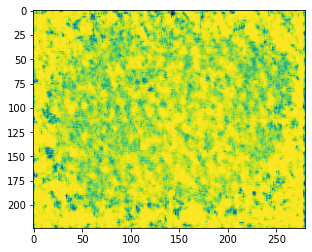

In [ ]:
plt.imshow(gen_imgs[0,:,:,0])

1/1 [==============================] - 0s 415ms/step


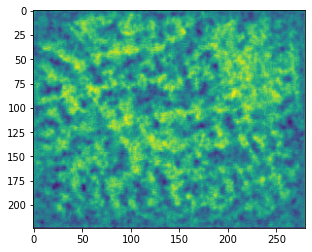

In [ ]:
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = dcgan.generator.predict(noise)
plt.imshow(gen_imgs[0,:,:,0])

1/1 [==============================] - 1s 649ms/step


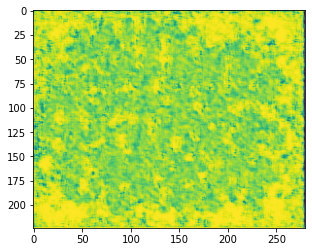

In [ ]:
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = dcgan.generator.predict(noise)
plt.imshow(gen_imgs[0,:,:,0])